In [71]:
import gensim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_confustion_matrix import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from collections import Counter
from sklearn import metrics
from xgboost import XGBClassifier


In [2]:
path2data = r"C:\Users\samer\Documents\university\anfänger_praktikum\harambee\ej_formal_shareable.csv"
df = pd.read_csv(path2data)
df = df.drop("Unnamed: 0", axis=1)
df = df[df["job_category"].isin(["Unclassified"]) == False]
df.head(3)

label2id = {}
for idx, category in enumerate(df.job_category.unique().tolist()):
    label2id[category] = idx


id2label = {}
for k,v in label2id.items():
    id2label[v] = k
    
df['label'] = df['job_category'].apply(lambda x :label2id[x])
df['tokenized_text'] = df.job_title.apply(lambda x:str.lower(x).split(" "))
df
df.head(3)

,job_title,frequency,job_category,label,tokenized_text
0,Cleaner,118,cleaner,0,[cleaner]
1,Education assistant,95,education assistant,1,"[education, assistant]"
2,Driver,91,driver,2,[driver]


<BarContainer object of 38 artists>

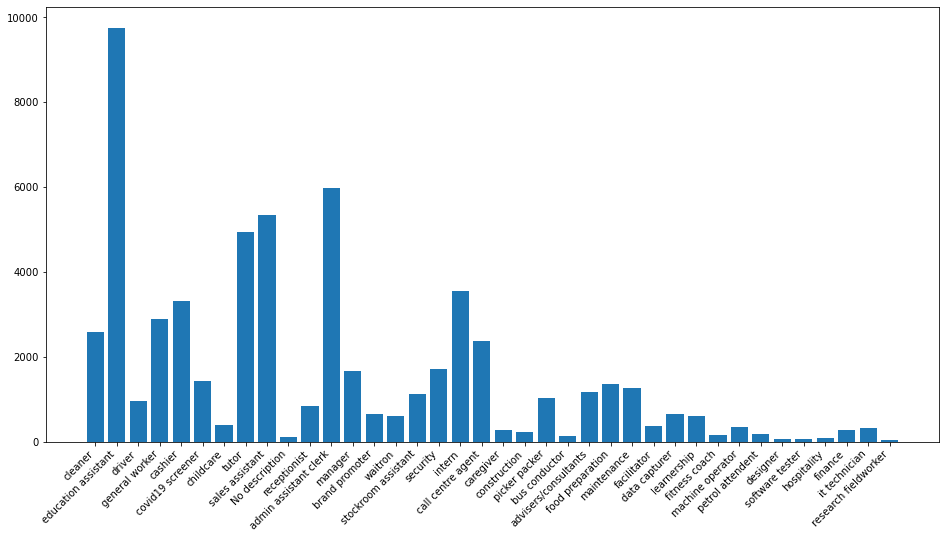

In [3]:
df_counter = Counter(df.job_category)
plt.figure(figsize=(16,8))
plt.xticks(rotation=45, ha='right')
plt.bar(df_counter.keys(), df_counter.values())

### xgboost without balancing data

In [4]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split (df['tokenized_text'], df['label'] , test_size=0.2)

# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=128,
                                   window=5,
                                   min_count=2)

In [6]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

C:\Users\samer\AppData\Local\Temp\ipykernel_21532\22094319.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
C:\Users\samer\AppData\Local\Temp\ipykernel_21532\22094319.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


In [7]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(128, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(128, dtype=float))

In [11]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train_vect_avg, list(y_train))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [12]:
len(X_test_vect_avg[0])

128

In [14]:
# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test_vect_avg)

In [16]:
f1_score(y_test, y_pred, average='weighted')

0.9422161741344961

In [15]:
print(classification_report(y_test, y_pred, target_names= list(id2label.values()))) #

                       precision    recall  f1-score   support

              cleaner       0.76      0.91      0.83       493
  education assistant       0.99      0.99      0.99      1993
               driver       0.97      0.92      0.94       193
       general worker       0.98      0.98      0.98       544
              cashier       0.90      0.89      0.89       632
     covid19 screener       0.98      0.96      0.97       257
            childcare       0.91      0.86      0.88        83
                tutor       0.97      0.97      0.97       994
      sales assistant       0.94      0.94      0.94      1125
       No description       0.96      0.84      0.90        32
         receptionist       0.96      0.91      0.94       171
admin assistant clerk       0.95      0.96      0.96      1215
              manager       0.96      0.95      0.95       338
       brand promoter       0.97      0.94      0.95       157
              waitron       0.95      0.86      0.90  

In [78]:
from plot_confustion_matrix import plot_confusion_matrix


In [102]:
def mix_with(cm):
    total_list = []
    n_classes = cm.shape[0]
    for i in range(n_classes):
        dict_ = dict()
        class_number = i
        top_guessed = pd.DataFrame(cm[:,i]).sort_values(0, ascending=False).head(3).index.tolist()
        if(top_guessed[0] == i):
            top_miss_predicted = top_guessed[1:]
        else:
            top_miss_predicted = top_guessed[:2]
        dict_['class'] = i
        dict_['FN'] = top_miss_predicted
        total_list.append(dict_)
    return total_list

In [114]:
len(list(id2label.values()))

38

In [117]:
FN_list = mix_with(x)
pd.DataFrame(FN_list, index=[list(id2label.values())]) #

,class,FN
cleaner,0,"[4, 8]"
education assistant,1,"[3, 7]"
driver,2,"[22, 3]"
general worker,3,"[1, 14]"
cashier,4,"[8, 0]"
covid19 screener,5,"[0, 17]"
childcare,6,"[5, 0]"
tutor,7,"[1, 8]"
sales assistant,8,"[4, 7]"
No description,9,"[37, 36]"


In [124]:
check_classes = ['cleaner', 'sales assistant', 'cashier', 'admin assistant clerk' , 'intern']
dict_counts = []
for i in check_classes:
    num_samples = df[df['job_category'] == i].shape
    dict_temp = {}
    dict_temp['class'] = i
    dict_temp['smaples'] = num_samples
    dict_counts.append(dict_temp)
dict_counts

[{'class': 'cleaner', 'smaples': (2604, 5)},
 {'class': 'sales assistant', 'smaples': (5357, 5)},
 {'class': 'cashier', 'smaples': (3312, 5)},
 {'class': 'admin assistant clerk', 'smaples': (5979, 5)},
 {'class': 'intern', 'smaples': (3566, 5)}]

In [118]:
## cleaner, sales assistant, cashier, admin assistant clerk and intern
fns_ = []
for i in FN_list:
    fns_ += (i['FN'])
Counter(fns_).most_common(5)

[(0, 16), (8, 7), (4, 5), (17, 5), (11, 5)]

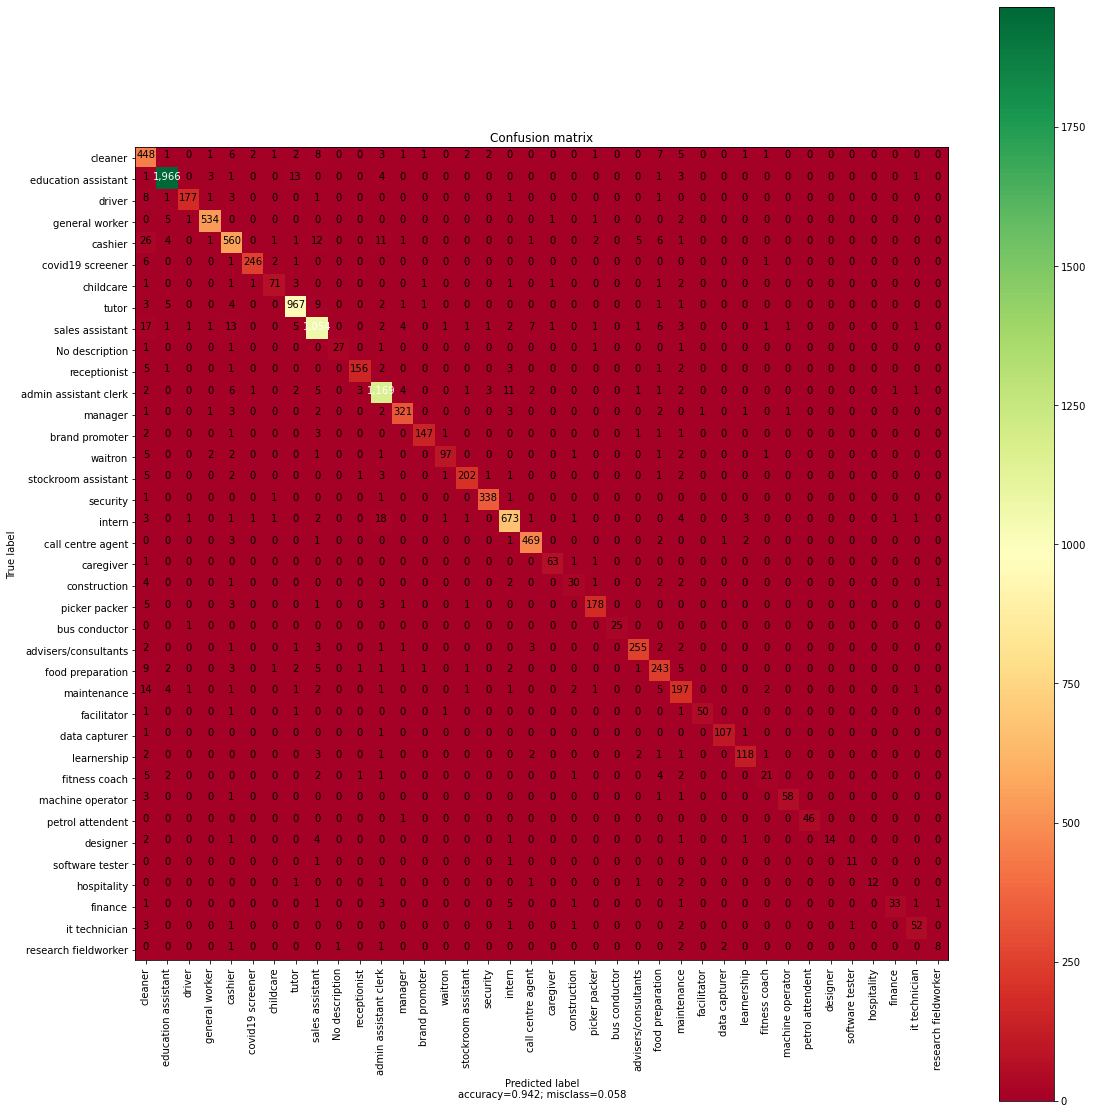

In [127]:
x = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(x, list(id2label.values()) , cmap="RdYlGn")

# TPR and FPR

In [145]:
cnf_matrix = x

In [184]:
# from the confustion matrix

def get_pn_from_cm(cm):
    FP = x.sum(axis=0) - np.diag(x)  
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    return FP,FN,TP,TN

def get_fpr(FP,TN):
    # (number of fasle positives) / (number of false positives + number of true negatives)
    return FP/(FP+TN)
def get_TPR(TP,FP)

In [165]:
y_pred

array([ 3,  1, 24, ..., 16, 27,  4], dtype=int64)

In [170]:
def binarize(true, pred, n_classes):

    return label_binarize(true, classes=n_classes), label_binarize(pred, classes=n_classes)
    
true_bin , pred_bin = binarize(y_test.tolist(), y_pred, list(range(38)))


In [185]:
cm_ = confusion_matrix(true_bin[:,1], pred_bin[:,1])
get_pn_from_cm(cm_)

(array([140,  26,   5,  10,  63,   5,   7,  33,  66,   1,   6,  64,  15,
          4,   5,   8,   7,  37,  17,   3,   8,   9,   0,  12,  47,  53,
          1,   3,   9,   7,   2,   0,   0,   1,   0,   2,   6,   2],
       dtype=int64),
 array([45, 27, 16, 10, 72, 11, 12, 27, 71,  5, 15, 46, 17, 10, 16, 17,  4,
        40, 10,  3, 13, 14,  1, 16, 35, 37,  5,  3, 13, 18,  6,  1, 10,  2,
         6, 14,  9,  7], dtype=int64),
 array([ 448, 1966,  177,  534,  560,  246,   71,  967, 1054,   27,  156,
        1169,  321,  147,   97,  202,  338,  673,  469,   63,   30,  178,
          25,  255,  243,  197,   50,  107,  118,   21,   58,   46,   14,
          11,   12,   33,   52,    8], dtype=int64),
 array([11194,  9808, 11629, 11273, 11132, 11565, 11737, 10800, 10636,
        11794, 11650, 10548, 11474, 11666, 11709, 11600, 11478, 11077,
        11331, 11758, 11776, 11626, 11801, 11544, 11502, 11540, 11771,
        11714, 11687, 11781, 11761, 11780, 11803, 11813, 11809, 11778,
        11760,

In [176]:

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(38):
    cm = confusion_matrix(true_bin[:,1], pred_bin[:,1])
    fpr[i], tpr[i], _ = metrics.roc_curve(true_bin[:, i], pred_bin[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

In [178]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(true_bin.ravel(), pred_bin.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

In [180]:
fpr

{0: array([0.        , 0.01235221, 1.        ]),
 1: array([0.        , 0.00264389, 1.        ]),
 2: array([0.00000000e+00, 4.29774798e-04, 1.00000000e+00]),
 3: array([0.00000000e+00, 8.86289108e-04, 1.00000000e+00]),
 4: array([0.        , 0.00562751, 1.        ]),
 5: array([0.00000000e+00, 4.32152118e-04, 1.00000000e+00]),
 6: array([0.00000000e+00, 5.96049046e-04, 1.00000000e+00]),
 7: array([0.        , 0.00304625, 1.        ]),
 8: array([0.        , 0.00616707, 1.        ]),
 9: array([0.00000000e+00, 8.47816872e-05, 1.00000000e+00]),
 10: array([0.00000000e+00, 5.14756349e-04, 1.00000000e+00]),
 11: array([0.        , 0.00603091, 1.        ]),
 12: array([0.       , 0.0013056, 1.       ]),
 13: array([0.00000000e+00, 3.42759212e-04, 1.00000000e+00]),
 14: array([0.00000000e+00, 4.26839679e-04, 1.00000000e+00]),
 15: array([0.00000000e+00, 6.89179876e-04, 1.00000000e+00]),
 16: array([0.0000000e+00, 6.0949064e-04, 1.0000000e+00]),
 17: array([0.        , 0.00332913, 1.        

## balance data

In [36]:
mean_counts = np.mean(list(Counter(df.job_category).values()))

def get_samples_category(df, category):
    category_df = df[df["job_category"] == category]
    if(category_df.shape[0] >1500):
        samples_category = category_df.sample(1500)
        return samples_category
    else:
        return category_df
    
categories = list(df.job_category.unique())
dfs = []
dfs = [get_samples_category(df,c) for c in categories]
len(dfs)

38

In [38]:
df_balanced = pd.concat(dfs)
df_balanced.shape

(31421, 5)

<BarContainer object of 38 artists>

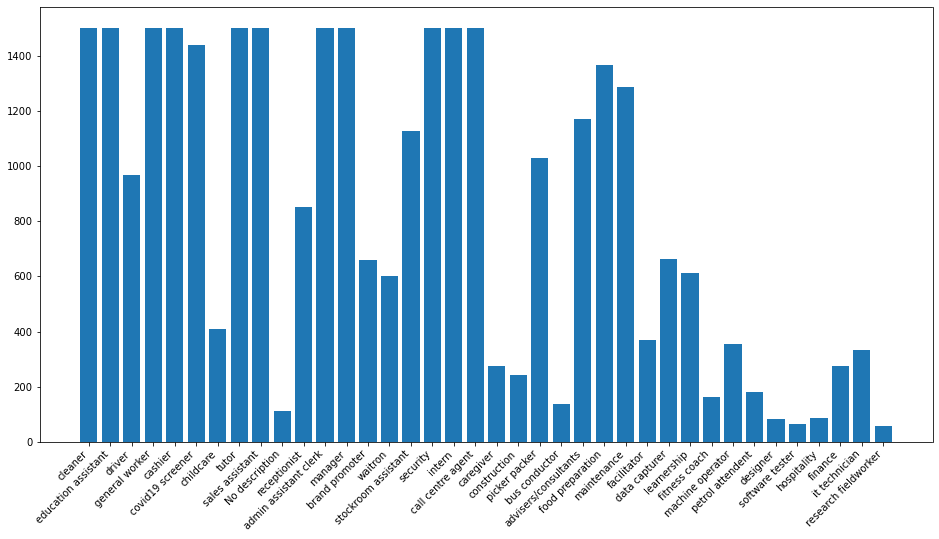

In [39]:
df_balanced_counter = Counter(df_balanced.job_category)
plt.figure(figsize=(16,8))
plt.xticks(rotation=45, ha='right')
plt.bar(df_balanced_counter.keys(), df_balanced_counter.values())

In [40]:
# Split data into train and test sets
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split (df_balanced['tokenized_text'], df_balanced['label'] , test_size=0.2)

# Train the word2vec model
w2v_model_b = gensim.models.Word2Vec(X_train_b,
                                   vector_size=128,
                                   window=5,
                                   min_count=2)

In [41]:
words_b = set(w2v_model_b.wv.index_to_key )
X_train_vect_b = np.array([np.array([w2v_model_b.wv[i] for i in ls if i in words_b])
                         for ls in X_train_b])
X_test_vect_b = np.array([np.array([w2v_model_b.wv[i] for i in ls if i in words_b])
                         for ls in X_test_b])

C:\Users\samer\AppData\Local\Temp\ipykernel_21532\517954709.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect_b = np.array([np.array([w2v_model_b.wv[i] for i in ls if i in words_b])
C:\Users\samer\AppData\Local\Temp\ipykernel_21532\517954709.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect_b = np.array([np.array([w2v_model_b.wv[i] for i in ls if i in words_b])


In [42]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg_b = []
for v in X_train_vect_b:
    if v.size:
        X_train_vect_avg_b.append(v.mean(axis=0))
    else:
        X_train_vect_avg_b.append(np.zeros(128, dtype=float))
        
X_test_vect_avg_b = []
for v in X_test_vect_b:
    if v.size:
        X_test_vect_avg_b.append(v.mean(axis=0))
    else:
        X_test_vect_avg_b.append(np.zeros(128, dtype=float))

In [43]:
# fit model no training data
model_balanced = XGBClassifier()
model_balanced.fit(X_train_vect_avg_b, list(y_train_b))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [44]:
# Use the trained model to make predictions on the test data
y_pred_b = model_balanced.predict(X_test_vect_avg_b)

In [46]:
f1_score(y_test_b, y_pred_b, average='weighted')

0.9118870003858042

In [47]:
print(classification_report(y_test_b, y_pred_b, target_names= list(id2label.values()))) #

                       precision    recall  f1-score   support

              cleaner       0.73      0.85      0.79       331
  education assistant       0.95      0.96      0.95       309
               driver       0.97      0.95      0.96       195
       general worker       0.97      0.99      0.98       282
              cashier       0.89      0.89      0.89       306
     covid19 screener       0.98      0.96      0.97       299
            childcare       0.97      0.85      0.91        74
                tutor       0.99      0.92      0.95       285
      sales assistant       0.90      0.85      0.87       282
       No description       0.79      0.69      0.73        16
         receptionist       0.98      0.94      0.96       174
admin assistant clerk       0.91      0.90      0.90       305
              manager       0.91      0.95      0.93       301
       brand promoter       0.97      0.92      0.95       144
              waitron       0.95      0.93      0.94  